In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#### Utils

##### PatchEmbed

In [2]:
class PatchEmbed(nn.Module):
    def __init__(self, kernel_size, stride, padding, in_chans, embed_dim):
        super().__init__()
        self.proj = nn.Conv2d(
            in_chans, embed_dim, kernel_size=kernel_size, stride=stride,
            padding=padding
        )
    
    def forward(self, x):
        x = self.proj(x)
        # b,c,h,w -> b,h,w,c
        x = x.permute(0, 2, 3, 1)
        return x

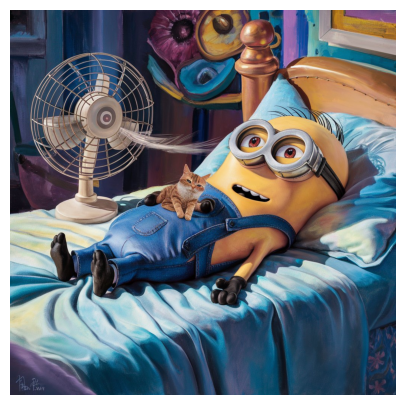

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rcParams['figure.figsize'] = [10, 5]

test_image = Image.open('./minion_img.jpeg')
test_image = np.array(test_image)
plt.imshow(test_image)
plt.axis('off')
plt.show()

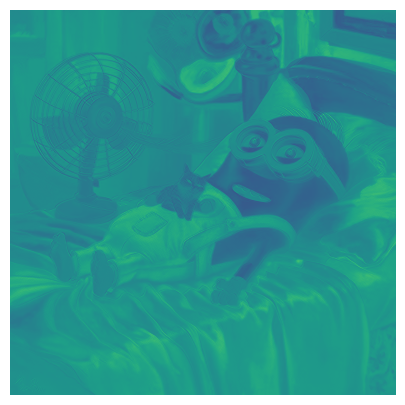

In [4]:
# warmup conv2d (@fastai)
test_image = Image.open('./minion_img.jpeg')
test_image = np.array(test_image)
test_image = torch.from_numpy(test_image)

top_edge_kernel = torch.tensor([
    [[-1, -1, -1],
     [0, 0, 0],
     [1, 1, 1]],
    
    [[-1, 0, 1],
     [-1, 0, 1],
     [-1, 0, 1]],
    
    [[1, 1, 1],
     [0, 0, 0],
     [-1, -1, -1]]
]).float()


def apply_kernel(row, col, kernel, img):
    return (img[row-1:row+2, col-1:col+2] * kernel).sum()

rng = range(1, test_image.shape[0]-2)
after_conv_img = torch.tensor([[apply_kernel(i, j, top_edge_kernel, test_image) for j in rng] for i in rng])
plt.axis('off')
plt.imshow(after_conv_img)
plt.show()


torch.Size([27, 1044484]) torch.Size([1, 1024, 1024, 3]) torch.Size([27]) torch.Size([1022, 1022])


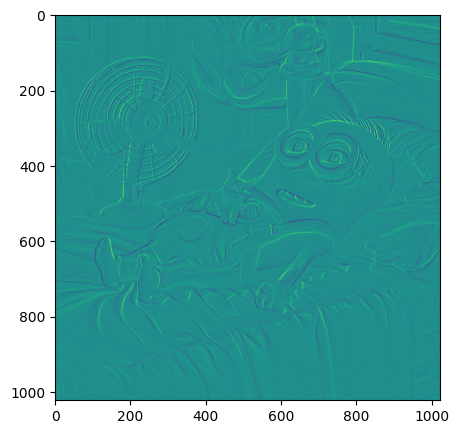

In [5]:
inp = test_image[None, :, :].float()
inp_unf = F.unfold(inp.permute(0, 3, 1, 2), (3, 3))[0]
kernel_weight = top_edge_kernel.view(-1)
output_img = (kernel_weight @ inp_unf).view(1022, 1022)
print(inp_unf.shape, inp.shape, kernel_weight.shape, output_img.shape)
plt.imshow(output_img)
plt.show()

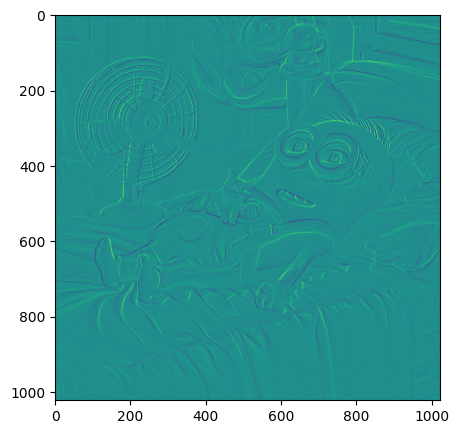

In [6]:
output_img2 = F.conv2d(inp.permute(0, 3, 1, 2), top_edge_kernel[None])
plt.imshow(output_img2[0][0])
plt.show()

In [7]:
inp.shape

torch.Size([1, 1024, 1024, 3])

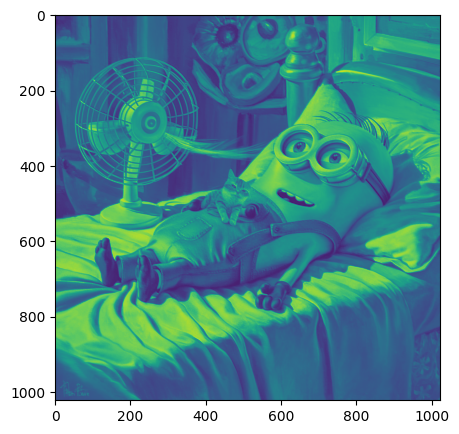

In [8]:
output_img3 = nn.Conv2d(3, 1, kernel_size=3)(inp.permute(0, 3, 1, 2))
plt.imshow(output_img3[0][0].cpu().detach())
plt.show()

In [9]:
PatchEmbed(kernel_size=3, stride=3, padding=0, in_chans=3, embed_dim=64)(inp.permute(0, 3, 1, 2)).shape

torch.Size([1, 341, 341, 64])

##### window_partition

In [10]:
def window_partition(x, window_size):
    B, H, W, C = x.shape

    # this is for padding calculation, such that height and width can be multiplied by window_size
    # H % window_size : gives reminder
    # window_size - H % window_size: subtracting reminder from window_size will how much extra we need to add.
    # final  % window_size make sure to handle already dividable cases.
    pad_h = (window_size - H % window_size) % window_size
    pad_w = (window_size - W % window_size) % window_size


    if pad_h > 0 or pad_w > 0:
        # order of padding right to lef so in our case (C, W, H)
        # for each dim you can pad two sides. here we only need to pad one side of hight and width
        x = F.pad(x, (0, 0, 0, pad_w, 0, pad_h))
    
    Hp, Wp = H + pad_h, W + pad_w

    # make it a view square of hight and width (B, window_size, window_size, window_size, window_size, C)
    x = x.view(B, Hp//window_size, window_size, Wp//window_size, window_size, C)

    # move height window with the corresponding width window this can be done by swapping 2,3 dim to 3,2
    windows = x.permute(0, 1, 3, 2, 4, 5)
    
    # now expand each window to across the batch
    # contiguous required because permute destroys items in contiguous memory but view required items
    # need to be in contiguous memory
    windows = windows.contiguous().view(-1, window_size, window_size, C)
    
    return windows, (Hp, Wp)

In [11]:
x = torch.randn(1, 7, 7, 4).float()

x_t, _ = window_partition(x, window_size=3)
x.shape, x_t.shape


(torch.Size([1, 7, 7, 4]), torch.Size([9, 3, 3, 4]))

##### window_unpartition

In [12]:
def window_unpartition(windows, window_size, pad_hw, hw):
    Hp, Wp = pad_hw
    H, W = hw

    # we need to divide that by total number of windows to recover original batch size
    # total number of windows =  (Hp * Wp // window_size // window_size)
    B = windows.shape[0] // (Hp * Wp // window_size // window_size)
    
    # move the windows from from the batch dim to individual batch
    x = windows.view(B, Hp // window_size, Wp // window_size, window_size, window_size, -1)
    
    # swap the height and width 
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous()

    # original dim conversion
    x = x.view(B, Hp, Wp, -1)

    # remove added padding
    if Hp > H or Wp > W:
        x = x[:, :H, :W, :].contiguous()

    return x

In [13]:
x = torch.randn(1, 7, 7, 4).float()

x_t, pad_hw = window_partition(x, window_size=3)
x.shape, x_t.shape


(torch.Size([1, 7, 7, 4]), torch.Size([9, 3, 3, 4]))

In [14]:
x_r = window_unpartition(x_t, 3, pad_hw, hw=(7, 7))
x_r.shape

torch.Size([1, 7, 7, 4])

##### DropPath

In [15]:
# dropout helper 
class DropPath(nn.Module):
    def __init__(self, drop_prop=0.0, scale_by_keep=True):
        super().__init__()
        self.drop_prop = drop_prop
        self.scale_by_keep = scale_by_keep

    def forward(self, x):
        if self.drop_prop == 0.0 or not self.training:
            return x
        
        keep_prob = 1 - self.drop_prop
        
        # calc shape which make all other dim shape 1 except 1 for B,H,W,C -> (B, 1, 1, 1)
        shape = (x.shape[0],) + (1, ) * (x.ndim -1)

        # create empty tensor with 0 values
        # then do bernouli sampling basically. make certain zeros 1 with keep prop
        random_tensor = x.new_empty(shape).bernoulli_(keep_prob)

        if keep_prob > 0.0 and self.scale_by_keep:
            # boost the 1 with prop percentage, this usually done to compensate for zeros.
            random_tensor.div_(keep_prob)
        
        # perform dropout on input
        return x * random_tensor
        
        

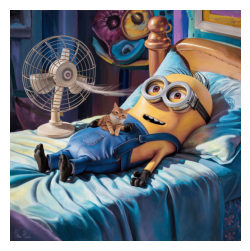

In [18]:
plt.figure(figsize=(3, 3))
plt.imshow(test_image)
plt.axis('off')
plt.show()

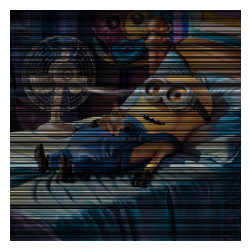

In [19]:
after_dropout = DropPath(drop_prop=0.6, scale_by_keep=False)(test_image.to(torch.float64))
after_dropout = after_dropout.to(torch.uint8).detach().cpu()
plt.figure(figsize=(3, 3))
plt.imshow(after_dropout)
plt.axis('off')
plt.show()



##### MLP

In [20]:
# multi layer perceptron
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, 
                 activation = nn.ReLU, sigmoid_output=False):
        super().__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(
            nn.Linear(n, k) for n, k in zip([input_dim]+h, h+[output_dim])
        )
        self.sigmoid_output = sigmoid_output
        self.act = activation()
    
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = self.act(layer(x)) if i < self.num_layers -1 else layer(x)
        if self.sigmoid_output:
            x = F.sigmoid(x)
        return x

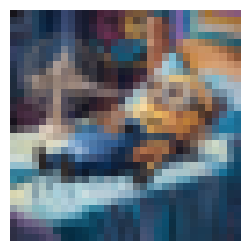

(torch.Size([1024, 1024, 3]), torch.Size([32, 32, 3]))

In [101]:
# mlp expensive operations if inp dim large (use low resolution for test)
import torchvision.transforms as TF
mpl.rcParams['figure.figsize'] = (3, 3)

reduce_sz = TF.Compose([
    TF.Resize((32, 32))
])
lres_img = reduce_sz(test_image.permute(2, 0, 1)).permute(1, 2, 0)
plt.imshow(lres_img)
plt.axis('off')
plt.show()
test_image.shape, lres_img.shape

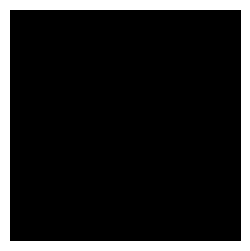

In [105]:
# single pass
inp = lres_img.to(torch.float32).contiguous().view(-1)
mlp = MLP(inp.shape[0], 2, inp.shape[0], 3)
o = mlp(inp)
o = o.view(lres_img.shape)
o = o.to(torch.uint8).detach().cpu()
plt.imshow(o)
plt.axis('off')
plt.show()

tensor(4.9910, grad_fn=<MinBackward1>) tensor(247.2456, grad_fn=<MaxBackward1>) 0.8859261870384216


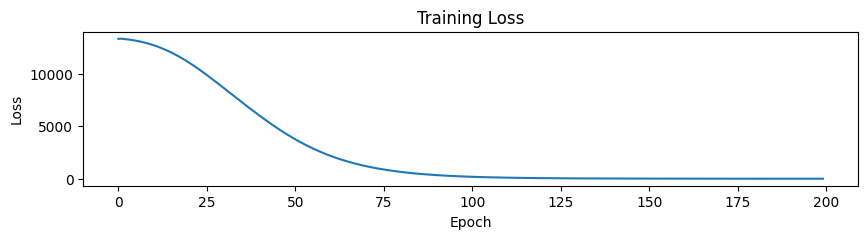

In [174]:
# identiy learning with mlp testing
losses = []
mlp = MLP(inp.shape[0], 20, inp.shape[0], 5)
opt = torch.optim.Adam(mlp.parameters(), lr=0.001)
inp = lres_img.to(torch.float32).contiguous().view(-1)
for _ in range(200):
    pred = mlp(inp)
    loss = F.mse_loss(pred, inp)
    loss.backward()

    # optim (1) this direct update. this takes much slower and longer iteration time

    # with torch.no_grad():
    #     for p in mlp.parameters():
    #         p.data -= 0.00001 * p.grad
    #         p.grad.zero_()

    # optim (2) adam optimizer, it tracks how gradient changes for each paramters and use that info
    # to update much faster like adaptive updating.

    # core idea is simple if gradient is high reduces the parameter gradient update value, 
    # if gradient is small increase the paramter gradient update value. and it's tracked/caclauted for all
    # parameters independtly
    # https://arxiv.org/pdf/1412.6980

    # algo:    

    opt.step()
    opt.zero_grad()

    losses.append(loss.item())

mlp.eval()
print(pred.min(), pred.max(), loss.item())
plt.figure(figsize=(10, 2))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

tensor(4.9910) tensor(247.2456)
tensor(5, dtype=torch.uint8) tensor(247, dtype=torch.uint8)


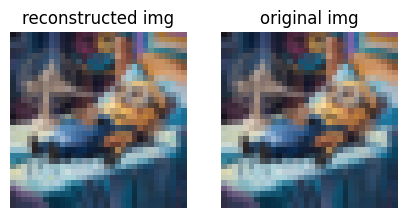

In [176]:

with torch.no_grad():
    _, axs = plt.subplots(1, 2, figsize=(5, 5))
    o = pred.to(torch.uint8)
    print(pred.min(), pred.max())
    print(lres_img.min(), lres_img.max())
    o = o.view(lres_img.shape)
    o = o.detach().cpu()
    axs[0].imshow(o)
    axs[0].set_title('reconstructed img')

    axs[0].axis('off')

    axs[1].imshow(lres_img)
    axs[1].set_title('original img')
    axs[1].axis('off')
    plt.show()

##### Adam Optimizer Algorithm (Note)



Input Parameters
- α: Step size (learning rate)
- β1, β2 ∈ [0, 1): Exponential decay rates for moment estimates
- f(θ): Stochastic objective function with parameters θ
- θ0: Initial parameter vector
- ε: Small constant for numerical stability

Initialization
```
m0 ← 0 (Initialize 1st moment vector)
v0 ← 0 (Initialize 2nd moment vector)
t ← 0 (Initialize timestep)
```

Algorithm
```python
while θt not converged do
    t ← t + 1
    
    // Compute gradient
    gt ← ∇θft(θt-1)
    
    // Update biased first moment estimate
    // Just keep track of avg gradient of the parameter. With β1 we can control how much
    // we allow influence of recent gradient vs existing gradient
    mt ← β1 · mt-1 + (1 - β1) · gt
    
    // Update biased second raw moment estimate
    // Similarly, this tracks the squared avg of current squared gradient vs existing squared gradient avg
    // This basically amplifies higher gradients even higher and lower gradients even lower
    vt ← β2 · vt-1 + (1 - β2) · gt^2
    
    // Compute bias-corrected first moment estimate
    // This 'bias correction' is because initially we guessed avg gradient value mt as zero.
    // So it's skewed towards zero. At the beginning of the iterations, we scale the avg a little higher
    // and as iteration time goes up, it won't have any effect.
    m̂t ← mt / (1 - β1^t)
    
    // Compute bias-corrected second raw moment estimate
    v̂t ← vt / (1 - β2^t)
    
    // Update parameters
    // The reason for dividing the avg gradient with avg squared gradient is because, for higher gradient
    // parameters it will be higher and make the update of the parameter low, and for small it will be even lower,
    // making the update much higher, sort of adapting update.
    // Quick note on why divide by square root of squared gradient avg: isn't that defeating the above mentioned purpose? No,
    // because we only focus on parameters with consistently higher gradients.
    θt ← θt-1 - α · m̂t / (√v̂t + ε)
end while

return θt  // Resulting parameters
```

 Notes
- The algorithm continues until convergence or a specified number of iterations.
- Typical default values are α = 0.001, β1 = 0.9, β2 = 0.999, and ε = 10^-8.
- The `^` symbol denotes exponentiation.
- √ denotes the square root operation.


##### LayerNorm

In [171]:

# idea is keep the standard input across layer inputs.
# the reason we do this to make it easy for the network to learn 
# without adjusting the gradient handle differnt input scales.
# and also helps with vanishing gradient and exploding gradient problem by keeping the inputs
# to the layers small and stable.
# https://arxiv.org/pdf/1607.06450


class LayerNorm2d(nn.Module):
    def __init__(self, num_channels, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps
    
    def forward(self, x):
        # calc mean across channedl dim (B, C, H, W) -> mean value shape (B, 1, H, W)
        # each bach calc mean independ of each calculater their own mean across channel dim.
        u = x.mean(1, keepdim=True)

        # calc variance
        s = (x-u).pow(2).mean(1, keepdim=True)

        # now normalize (just z-score)
        x = (x-u) / torch.sqrt(s+self.eps)

        # to avoid this hard restriction allow the model to adjust
        # if required mean and variance from standard dist (0 mean, 1 var).
        # just  mx+b and allow m and b learnable
        x = self.weight[:, None, None] * x + self.bias[:, None, None]
        
        return x
        
        

##### get_activation_fn

In [182]:
def get_activation_fn(activation):
    # makes all the negatie values to zero, and keep the positive value same.
    if activation == 'relu':
        return F.relu
    
    # gelu activation remove some hard cut off of negative value like relu, it allows some
    # small range of negative value after which it will make everythin to zero.
    # to acheive this effect we can take each value and multiply with s curve which 
    # goes to zero negative region smoothly and for postive goes to 1. 
    # cumulative distribution of normal distribution function actually this s function shape.
    # https://arxiv.org/pdf/1606.08415
    if activation == 'gelu':
        return F.gelu
    
    # same like glue multipled with s shaped curve but here choosen to be sigmoid instead of 
    # normal dist cdf.
    # one more changes return output will half of the input so input you need duplicated it twice.
    # https://arxiv.org/pdf/1612.08083
    if activation == 'glu':
        return F.glu
    
    

torch.Size([200, 1]) torch.Size([200])


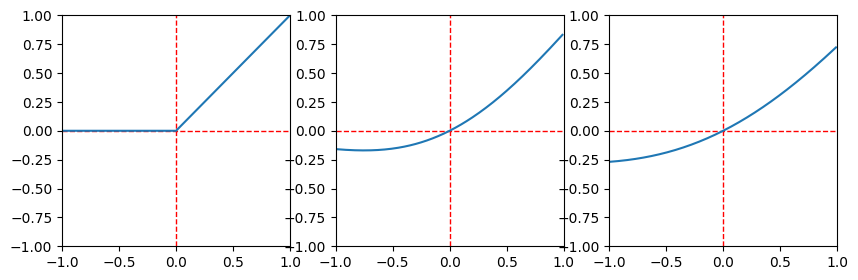

In [232]:
x = torch.arange(-1, 1, 0.01).float()

_, axs = plt.subplots(1, 3, figsize=(10, 3), )
for ax in axs.flat:
    ax.axvline(x=0, color='r', linestyle='--', linewidth=1)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.axhline(y=0, color='r', linestyle='--', linewidth=1)

relu_o = get_activation_fn('relu')(x)
axs[0].plot(x, relu_o)

gelu_o = get_activation_fn('gelu')(x)
axs[1].plot(x, gelu_o)

x_glu = torch.stack([x, x], dim=1)
glu_o = get_activation_fn('glu')(x_glu)
print(glu_o.shape, x.shape)
axs[2].plot(x, glu_o)

plt.show()

##### GLUE Activation (Note)

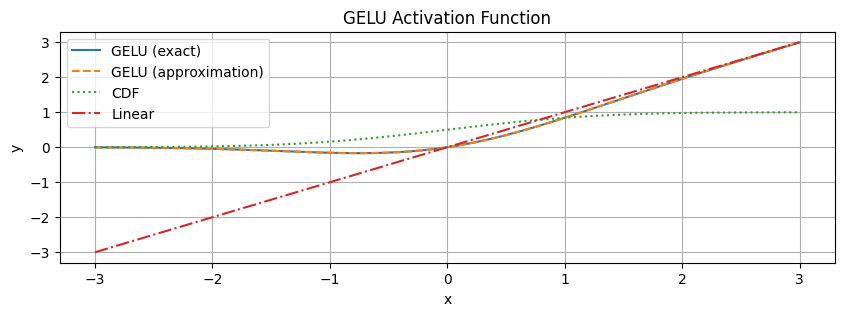

In [222]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

def gelu(x):
    return 0.5 * x * (1 + erf(x / np.sqrt(2)))

def gelu_approximation(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))

x = np.linspace(-3, 3, 1000)
y_gelu = gelu(x)
y_gelu_approx = gelu_approximation(x)
y_cdf = 0.5 * (1 + erf(x / np.sqrt(2)))

plt.figure(figsize=(10, 3))
plt.plot(x, y_gelu, label='GELU (exact)')
plt.plot(x, y_gelu_approx, label='GELU (approximation)', linestyle='--')
plt.plot(x, y_cdf, label='CDF', linestyle=':')
plt.plot(x, x, label='Linear', linestyle='-.')

plt.title('GELU Activation Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

##### get_1d_sine_pe (Sine Positional Embedding)

In [242]:
# https://arxiv.org/pdf/1706.03762
def get_1d_sine_pe(pos_inds, dim, temperature=10000):
    # split the dim in half. half dim we use for sine, and other half for the cos
    pe_dim = dim // 2

    # embedingge will be stored here
    dim_t = torch.arange(pe_dim, dtype=torch.float32)
    
    # this creates pairs of same numbers ('same frequency values') like [0, 0, 1, 1, 2, 2, ... pe_dim-1]
    # 2 * (dim_t // 2): convert [0, 1, 2, ..] to [0, 0, 1, 1, ...]
    # divide by pe_dim act as normalizaton, which brings the value between [0, 1]
    # why we square with the temperature, we will get geometric series multiple of temperature 
    # because we have values in betweent [0, 1] it will be geometric series between [1, temperature]
    dim_t = temperature ** (2 * (dim_t // 2) / pe_dim)
    print(dim_t)

    # each dim value divides its correspoinding position.
    # e.g pos(or ind) = 0 => [0/dim_0, 0/dim_1, 0/dim_2, ...]
    # e.g pos(or ind) = 2 => [2/dim_0, 0/dim_1, 2/dim_2, ...]
    # why we do this?
    pos_embed = pos_inds.unsqueeze(-1) / dim_t

    # this creates final embedding for each dimensions by creating sin and cos of each value.
    # why we do this?
    pos_embed = torch.cat([pos_embed.sin(), pos_embed.cos()], dim=-1)

    return pos_embed



tensor([1.0000e+00, 1.0000e+00, 1.7783e+00, 1.7783e+00, 3.1623e+00, 3.1623e+00,
        5.6234e+00, 5.6234e+00, 1.0000e+01, 1.0000e+01, 1.7783e+01, 1.7783e+01,
        3.1623e+01, 3.1623e+01, 5.6234e+01, 5.6234e+01, 1.0000e+02, 1.0000e+02,
        1.7783e+02, 1.7783e+02, 3.1623e+02, 3.1623e+02, 5.6234e+02, 5.6234e+02,
        1.0000e+03, 1.0000e+03, 1.7783e+03, 1.7783e+03, 3.1623e+03, 3.1623e+03,
        5.6234e+03, 5.6234e+03])


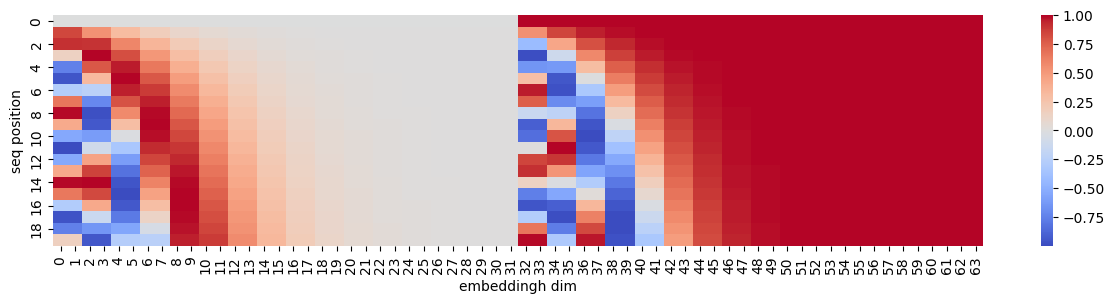

In [243]:
import seaborn as sns

seq_length = 20
embedding_dim = 64

positions = torch.arange(seq_length)
pe = get_1d_sine_pe(positions, embedding_dim)

plt.figure(figsize=(15, 3))
sns.heatmap(pe.numpy(), cmap='coolwarm', center=0)
plt.xlabel('embeddingh dim')
plt.ylabel('seq position')
plt.show()

##### select_closest_cond_frames

In [248]:
def select_closest_cond_frames(frame_idx, cond_frame_outputs, max_cond_frame_num):
    if max_cond_frame_num == -1 or len(cond_frame_outputs) <= max_cond_frame_num:
        selected_outputs = cond_frame_outputs
        unselected_outputs = {}
    else:
        assert max_cond_frame_num >= 2, 'conditioning frame should be >= 2'
        selected_outputs  = {}

        # pick previous frame
        idx_before = max((t for t in cond_frame_outputs if t < frame_idx), default=None)
        if idx_before is not None:
            selected_outputs[idx_before] = cond_frame_outputs[idx_before]

        # after frame
        idx_after = max((t for t in cond_frame_outputs if t >= frame_idx), default=None)
        if idx_after is not None:
            selected_outputs[idx_after] = cond_frame_outputs[idx_after]

        
        # pick other available closest frames
        num_remain = max_cond_frame_num - len(selected_outputs)
        inds_reamin = sorted((t for t in cond_frame_outputs if t not in selected_outputs), 
                             key=lambda x: abs(x-frame_idx))[:num_remain]
        selected_outputs.update((t, cond_frame_outputs[t]) for t in inds_reamin)
        unselected_outputs = {
            t: v for t, v in cond_frame_outputs.items() if t not in selected_outputs
        }
    return selected_outputs, unselected_outputs

In [256]:
cond_frame_outputs = {
    1: "Output 1",
    3: "Output 3",
    5: "Output 5",
    7: "Output 7",
    9: "Output 9",
    11: "Output 11"
}

frame_idx = 6
max_cond_frame_num = 3

selected, unselected = select_closest_cond_frames(frame_idx, cond_frame_outputs, max_cond_frame_num)

print(f"Current frame index: {frame_idx}")
print(f"Max conditioning frames: {max_cond_frame_num}")
print("\nSelected outputs:")
for k, v in selected.items():
    print(f"Frame {k}: {v}")
print("\nUnselected outputs:")
for k, v in unselected.items():
    print(f"Frame {k}: {v}")

Current frame index: 6
Max conditioning frames: 3

Selected outputs:
Frame 5: Output 5
Frame 11: Output 11
Frame 7: Output 7

Unselected outputs:
Frame 1: Output 1
Frame 3: Output 3
Frame 9: Output 9


##### hieradet (file)

##### Attention (Note)

In [334]:
# attention warmup
# https://github.com/rasbt/LLMs-from-scratch/blob/main/ch03/01_main-chapter-code/ch03.ipynb

In [333]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

In [339]:
query = inputs[1]

attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query)
attn_scores_2

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])

In [340]:
res = 0.
for idx, ele in enumerate(inputs[0]):
    res += inputs[0][idx] * query[idx]
print(res)
print(torch.dot(inputs[0], query))

tensor(0.9544)
tensor(0.9544)


In [342]:
attn_weights_2_temp = attn_scores_2 / attn_scores_2.sum()
attn_weights_2_temp, attn_weights_2_temp.sum()


(tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656]), tensor(1.0000))

In [344]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)
attn_weights_2_naive, attn_weights_2_naive.sum()

(tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581]), tensor(1.))

In [345]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
attn_weights_2, attn_weights_2.sum()

(tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581]), tensor(1.))

In [346]:
query = inputs[1]
context_vec_2 = torch.zeros(query.shape)
for i, x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i] * x_i
context_vec_2

tensor([0.4419, 0.6515, 0.5683])

In [349]:
attn_scores = torch.empty(6, 6)
for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [350]:
attn_scores =  inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [351]:
attn_weights = torch.softmax(attn_scores, dim=-1)
attn_weights

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])

In [352]:
all_context_vecs = attn_weights @ inputs
all_context_vecs

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])

In [353]:
context_vec_2

tensor([0.4419, 0.6515, 0.5683])

In [355]:
x_2 = inputs[1]
d_in = inputs.shape[1]
d_out = 2

In [356]:
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

In [359]:
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value
query_2, key_2, value_2

(tensor([0.9737, 0.9753]), tensor([1.5003, 1.6275]), tensor([0.9806, 0.8307]))

In [360]:
keys = inputs @ W_key
values = inputs @ W_value
keys.shape, values.shape


(torch.Size([6, 2]), torch.Size([6, 2]))

In [361]:
keys_2 = keys[1]
attn_score_22 = query_2.dot(keys_2)
attn_score_22

tensor(3.0482)

In [364]:
attn_scores_2 = query_2 @ keys.T
attn_scores_2

tensor([2.4291, 3.0482, 3.0221, 1.6029, 1.7024, 1.9700])

In [366]:
d_k = keys.shape[1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
attn_weights_2

tensor([0.1681, 0.2604, 0.2557, 0.0937, 0.1006, 0.1215])

In [367]:
d_k = keys.shape[1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)

tensor([0.1681, 0.2604, 0.2557, 0.0937, 0.1006, 0.1215])


In [368]:
context_vec_2 = attn_weights_2 @ values
context_vec_2

tensor([0.8224, 0.6726])

In [370]:
class SelfAttention_v1(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        keys = x @ self.W_key
        values = x @ self.W_value
        queries = x @ self.W_query

        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values

        return context_vec

In [371]:
sa_v1 = SelfAttention_v1(d_in, d_out)
sa_v1(inputs)

tensor([[0.3178, 0.9183],
        [0.3236, 0.9442],
        [0.3236, 0.9437],
        [0.3114, 0.8948],
        [0.3179, 0.9059],
        [0.3118, 0.9036]], grad_fn=<MmBackward0>)

In [372]:
class SelfAttention_v2(nn.Module):
    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        values = self.W_value(x)
        queries = self.W_query(x)

        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores/keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        
        return context_vec
        

In [373]:
sa_v2 = SelfAttention_v2(d_in, d_out)
sa_v2(inputs)

tensor([[0.0517, 0.4695],
        [0.0541, 0.4706],
        [0.0542, 0.4709],
        [0.0531, 0.4681],
        [0.0559, 0.4759],
        [0.0519, 0.4651]], grad_fn=<MmBackward0>)

In [376]:
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T

attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
attn_weights

tensor([[0.1690, 0.1715, 0.1715, 0.1609, 0.1654, 0.1618],
        [0.1592, 0.1713, 0.1709, 0.1668, 0.1613, 0.1704],
        [0.1588, 0.1718, 0.1715, 0.1666, 0.1609, 0.1705],
        [0.1628, 0.1672, 0.1671, 0.1685, 0.1647, 0.1697],
        [0.1535, 0.1806, 0.1798, 0.1617, 0.1547, 0.1697],
        [0.1665, 0.1621, 0.1622, 0.1710, 0.1687, 0.1695]],
       grad_fn=<SoftmaxBackward0>)

In [378]:
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
mask_simple

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])

In [379]:
masked_simple = attn_weights * mask_simple
masked_simple

tensor([[0.1690, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1592, 0.1713, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1588, 0.1718, 0.1715, 0.0000, 0.0000, 0.0000],
        [0.1628, 0.1672, 0.1671, 0.1685, 0.0000, 0.0000],
        [0.1535, 0.1806, 0.1798, 0.1617, 0.1547, 0.0000],
        [0.1665, 0.1621, 0.1622, 0.1710, 0.1687, 0.1695]],
       grad_fn=<MulBackward0>)

In [382]:
row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
masked_simple_norm

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4817, 0.5183, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3162, 0.3422, 0.3415, 0.0000, 0.0000, 0.0000],
        [0.2446, 0.2512, 0.2510, 0.2532, 0.0000, 0.0000],
        [0.1849, 0.2175, 0.2166, 0.1947, 0.1864, 0.0000],
        [0.1665, 0.1621, 0.1622, 0.1710, 0.1687, 0.1695]],
       grad_fn=<DivBackward0>)

In [388]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
masked
mask

tensor([[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])

In [389]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=-1)
attn_weights

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4817, 0.5183, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3162, 0.3422, 0.3415, 0.0000, 0.0000, 0.0000],
        [0.2446, 0.2512, 0.2510, 0.2532, 0.0000, 0.0000],
        [0.1849, 0.2175, 0.2166, 0.1947, 0.1864, 0.0000],
        [0.1665, 0.1621, 0.1622, 0.1710, 0.1687, 0.1695]],
       grad_fn=<SoftmaxBackward0>)

In [391]:
dropout = torch.nn.Dropout(0.5)
example = torch.ones(6, 6)
dropout(example)

tensor([[0., 2., 2., 0., 0., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 2., 0., 2., 0., 2.],
        [0., 0., 2., 2., 2., 2.],
        [0., 2., 0., 2., 0., 0.],
        [2., 0., 0., 0., 2., 0.]])

In [392]:
dropout(attn_weights)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.9635, 1.0365, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.6325, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5025, 0.0000, 0.5063, 0.0000, 0.0000],
        [0.3697, 0.4350, 0.0000, 0.3894, 0.3727, 0.0000],
        [0.0000, 0.3243, 0.3244, 0.3419, 0.3374, 0.3389]],
       grad_fn=<MulBackward0>)

In [394]:
batch = torch.stack((inputs, inputs), dim=0)
batch.shape

torch.Size([2, 6, 3])

In [ ]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) # 2 inputs with 6 tokens each, and each token has embedding dimension 3

In [395]:
class CausalAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2)
        attn_scores.masked_fill(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
        attn_weights = torch.softmax(attn_scores/keys.shape[-1]**0.5, dim=-1)
        
        context_vec = attn_weights @ values

        return context_vec

In [398]:
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)
context_vecs.shape

torch.Size([2, 6, 2])

In [400]:
class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList([CausalAttention(d_in, d_out, context_length, dropout, qkv_bias) for _ \
                                    in range(num_heads)])
    
    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)
    

In [405]:
context_length = batch.shape[1]
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(d_in, d_out, context_length, 0.0, num_heads=5)
context_vecs = mha(batch)
context_vecs.shape

torch.Size([2, 6, 10])

In [407]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), "d_out must be divisible my num_heads"
        
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))


    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)
        queries = queries.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)

        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec

In [410]:
batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
context_vecs.shape

torch.Size([2, 6, 2])

In [415]:
# (b, num_heads, num_tokens, head_dim) = (1, 2, 3, 4)
a = torch.tensor([[[[0.2745, 0.6584, 0.2775, 0.8573],
                    [0.8993, 0.0390, 0.9268, 0.7388],
                    [0.7179, 0.7058, 0.9156, 0.4340]],

                   [[0.0772, 0.3565, 0.1479, 0.5331],
                    [0.4066, 0.2318, 0.4545, 0.9737],
                    [0.4606, 0.5159, 0.4220, 0.5786]]]])
print(a.shape)
(a@a.transpose(2, 3)).shape

torch.Size([1, 2, 3, 4])


torch.Size([1, 2, 3, 3])

In [417]:
first_head = a[0, 0, :, :]
first_res = first_head @ first_head.T
first_head.shape, first_res.shape

(torch.Size([3, 4]), torch.Size([3, 3]))

In [418]:
second_head  = a[0, 1, :, :]
second_res = second_head @ second_head.T
second_head.shape, second_res.shape

(torch.Size([3, 4]), torch.Size([3, 3]))

##### MultiScaleAttention

##### scaled_dot_product_attention

In [446]:
import math

def scaled_dot_product_attention(query, key, value, attn_mask=None, dropout_p=0.0,
                                  is_causal=False, scale=None):
    # S, L - H*W shape (seq length of query, and key).
    L , S = query.size(-2), key.size(-2)

    # this is normalization factor in attention (1/sqrt(out_dim))
    scale_factor = 1 / math.sqrt(query.size(-1)) if scale is None else scale

    # ??
    attn_bias = torch.zeros(L, S, dtype=query.dtype)

    # this is for causal mask in attention which mask feature tokens
    if is_causal:
        assert attn_mask is None
        temp_mask = torch.ones(L, S, dtype=torch.bool).tril(diagonal=0)
        attn_bias.masked_fill(temp_mask.logical_not(), float('-inf'))
        attn_bias.to(query.dtype)

    # ??
    if attn_mask is not None:
        pass

    # query key dot product in attention operation
    attn_weight = query @ key.transpose(-2, -1) * scale_factor
    
    attn_weight += attn_bias

    # normalized the attention weight between [0, 1]
    attn_weight = torch.softmax(attn_weight, dim=-1)

    # will make cerntail weights to zero with prob of dropout_p
    attn_weight = torch.dropout(attn_weight, dropout_p, train=True)

    # final context vector
    return attn_weight @ value


In [475]:
def do_pool(x, pool=None, norm=None):
    if pool is None:
        return x
    
    # (B, H, W, C) -> (B, C, H, W)
    x = x.permute(0, 3, 1, 2)
    
    x = pool(x)

    x = x.permute(0, 2, 3, 1)
    
    if norm:
        x = norm(x)
    
    return x

In [476]:
batch_size, height, width, channels = 2, 6, 6, 3
x = torch.rand(batch_size, height, width, channels) * 5  

print('input shape', x.shape)

# this cut the size half in both width and height
pool = nn.MaxPool2d(kernel_size=2, stride=2)

pooled_x = do_pool(x, pool)

print('pooled x',  pooled_x.shape)
print('mean, std', pooled_x.mean(), pooled_x.std())

norm = nn.LayerNorm(channels)
pooled_norm = do_pool(x, pool, norm)
print('pooled norm', pooled_norm.shape)
print('mean, std', pooled_norm.mean(), pooled_norm.std())

input shape torch.Size([2, 6, 6, 3])
pooled x torch.Size([2, 3, 3, 3])
mean, std tensor(3.8885) tensor(0.8431)
pooled norm torch.Size([2, 3, 3, 3])
mean, std tensor(-1.7219e-07, grad_fn=<MeanBackward0>) tensor(1.0093, grad_fn=<StdBackward0>)


In [494]:
class MultiScaleAttention(nn.Module):
    def __init__(self, dim, dim_out, num_heads, q_pool=None):
        super().__init__()

        self.dim = dim
        self.dim_out = dim_out

        self.num_heads = num_heads
        head_dim = dim_out // num_heads
        self.scale = head_dim**-0.5

        self.q_pool = q_pool
        self.qkv = nn.Linear(dim, dim_out * 3)
        self.proj = nn.Linear(dim_out, dim_out)

    def forward(self, x):
        B, H, W, _ = x.shape

        # 3 is for query, key, value
        # this is shortcut way of getting query, key, value embeddigs by reshaping
        # and pulling respective ones.
        # reshape try to (B, H*W, 3, num_heads, dim_out//num_heads)
        qkv = self.qkv(x)
        print(qkv.shape)
        qkv = qkv.reshape(B, H*W, 3, self.num_heads, -1)
        print(qkv.shape)

        # extract query, key, value
        # q, k, v  each shape will be (B, H*W, num_heads, dim_out//num_heads)
        q, k, v = torch.unbind(qkv, 2)

        # q pooling, reduce the height and width of the query
        if self.q_pool:
            q = do_pool(q.reshape(B, H, W, -1), self.q_pool)

            # downsampled query height and width
            H, W = q.shape[1:3] 
            q = q.reshape(B, H*W, self.num_heads, -1)
        
        print(q.shape, k.shape, v.shape)
            

        # apply attention operation
        # attentions operation we have to peform attention operation independent of each head
        # so we need to transpose H*W with num_heads.
        # q,k,v shape after transpose will be (B, num_heads, H*W, dim_out//num_heads)
        x = scaled_dot_product_attention(
            q.transpose(1, 2),
            k.transpose(1, 2),
            v.transpose(1, 2),
        )

        print(x.shape)
        
        return x


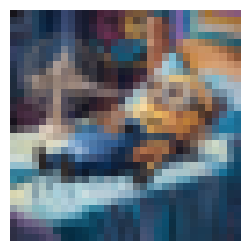

In [495]:
plt.imshow(lres_img)
plt.axis('off')
plt.show()

In [496]:
msa = MultiScaleAttention(dim=3, dim_out=64, num_heads=4)

inp = lres_img[None].clone().float()
batch_size, height, width, channel = inp.shape
print(inp.shape)
msa(inp);

torch.Size([1, 32, 32, 3])
torch.Size([1, 32, 32, 192])
torch.Size([1, 1024, 3, 4, 16])
torch.Size([1, 1024, 4, 16]) torch.Size([1, 1024, 4, 16]) torch.Size([1, 1024, 4, 16])
torch.Size([1, 4, 1024, 16])


In [497]:
pool = nn.MaxPool2d(kernel_size=2, stride=2)
msa = MultiScaleAttention(dim=3, dim_out=64, num_heads=4, q_pool=pool)
msa(inp);

torch.Size([1, 32, 32, 192])
torch.Size([1, 1024, 3, 4, 16])
torch.Size([1, 256, 4, 16]) torch.Size([1, 1024, 4, 16]) torch.Size([1, 1024, 4, 16])
torch.Size([1, 4, 256, 16])


In [498]:
x = torch.randn(5, 3, 5, 4)
t = torch.unbind(x, 2)
print(len(t))
for ele in t:
    print(ele.shape)

5
torch.Size([5, 3, 4])
torch.Size([5, 3, 4])
torch.Size([5, 3, 4])
torch.Size([5, 3, 4])
torch.Size([5, 3, 4])


In [3]:
class ImageEncoder(nn.Module):
    def __init__(self, trunk, neck, scalp=0):
        super().__init__()
        self.trunk = trunk
        self.neck = neck
        self.scalp = scalp
    
    def forward(self, sample):
        features, pos = self.neck(self.trunk(sample))
        
